# Comprehensive AI vs Human Rater Analysis

Advanced comparison of Llama AI scoring vs Human Recruiter and Service Owner ratings.

## Analysis Sections

1. **Setup & Data Loading**
2. **Overall Agreement Metrics**
   - Inter-rater reliability (ICC, Cohen's Kappa)
   - Agreement rates at different thresholds
   - Correlation analysis
3. **Score Distribution Analysis**
   - Distribution comparison plots
   - Statistical tests for differences
   - Bias detection
4. **Metric-by-Metric Deep Dive**
   - Per-metric agreement
   - Bland-Altman plots
   - Confusion matrices
5. **Disagreement Analysis**
   - High-disagreement cases
   - Systematic bias patterns
   - Agreement heatmaps
6. **Summary & Recommendations**

## 1. Setup & Data Loading

In [ ]:
# Install required packages
pip install pandas numpy scipy matplotlib seaborn pingouin -q

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr, wilcoxon, mannwhitneyu
import pingouin as pg  # For ICC and advanced statistics
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [8]:
# Load data
llamaPath = '/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/metaResults/final_meta-llama_Llama-3.1-8B-Instruct_novita_20251104-234821.csv'
recruiterPath = '/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/candidates_v2_recruiter_graded.csv'
ownerPath = '/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/candidates_v2_service_owner_graded.csv'

llama_df = pd.read_csv(llamaPath)
recruiter_raw = pd.read_csv(recruiterPath)
owner_raw = pd.read_csv(ownerPath)

print(f"Loaded data:")
print(f"  Llama: {llama_df.shape[0]} interviews")
print(f"  Recruiter: {recruiter_raw.shape[0]} interviews")
print(f"  Service Owner: {owner_raw.shape[0]} interviews")

Loaded data:
  Llama: 49 interviews
  Recruiter: 50 interviews
  Service Owner: 50 interviews


In [9]:
# Parse human scores (extract numeric scores from "N – justification" format)
METRICS_HUMAN = ["Cognitive ability", "Experience", "Problem Solving", 
                 "Reliability", "Professionalism", "Communication"]

def extract_score_and_justification(df, metric_cols):
    """Extract numeric scores from human rating format."""
    out = df.copy()
    for metric in metric_cols:
        base = metric.lower().replace(" ", "_")
        score_col = f"{base}_score"
        just_col = f"{base}_justification"
        # Extract numeric score
        out[score_col] = out[metric].str.extract(r'(\d+)').astype(float)
        # Extract justification
        out[just_col] = out[metric].str.replace(r'^\s*\d+\s*[–-]\s*', '', regex=True).str.strip()
    return out

recruiter_df = extract_score_and_justification(recruiter_raw, METRICS_HUMAN)
owner_df = extract_score_and_justification(owner_raw, METRICS_HUMAN)

print("\n✓ Parsed human scores")


✓ Parsed human scores


In [10]:
# Define metric columns
METRICS = ["cognitive_ability", "experience", "problem_solving", 
           "reliability", "professionalism", "communication"]
SCORE_COLS = [f"{m}_score" for m in METRICS]

# Create unified dataframe for analysis
def prepare_comparison_df(llama, recruiter, owner):
    """Merge all three scoring sources by interview_id."""
    # Select relevant columns
    llama_scores = llama[['interview_id'] + SCORE_COLS].copy()
    recruiter_scores = recruiter[['interview_id'] + SCORE_COLS].copy()
    owner_scores = owner[['interview_id'] + SCORE_COLS].copy()
    
    # Rename columns with suffix
    llama_scores.columns = ['interview_id'] + [f"{c}_llama" for c in SCORE_COLS]
    recruiter_scores.columns = ['interview_id'] + [f"{c}_recruiter" for c in SCORE_COLS]
    owner_scores.columns = ['interview_id'] + [f"{c}_owner" for c in SCORE_COLS]
    
    # Merge
    df = llama_scores.merge(recruiter_scores, on='interview_id', how='outer')
    df = df.merge(owner_scores, on='interview_id', how='outer')
    
    return df

comparison_df = prepare_comparison_df(llama_df, recruiter_df, owner_df)

print(f"\n✓ Created comparison dataframe: {comparison_df.shape[0]} interviews")
print(f"  Available comparisons:")
print(f"    Llama vs Recruiter: {comparison_df[[c for c in comparison_df.columns if 'llama' in c][0]].notna().sum()}")
print(f"    Llama vs Owner: {comparison_df[[c for c in comparison_df.columns if 'owner' in c][0]].notna().sum()}")

display(comparison_df.head())


✓ Created comparison dataframe: 50 interviews
  Available comparisons:
    Llama vs Recruiter: 49
    Llama vs Owner: 50


,interview_id,cognitive_ability_score_llama,experience_score_llama,problem_solving_score_llama,reliability_score_llama,professionalism_score_llama,communication_score_llama,cognitive_ability_score_recruiter,experience_score_recruiter,problem_solving_score_recruiter,reliability_score_recruiter,professionalism_score_recruiter,communication_score_recruiter,cognitive_ability_score_owner,experience_score_owner,problem_solving_score_owner,reliability_score_owner,professionalism_score_owner,communication_score_owner
0,intv_0001,9.0,8.0,8.0,8.0,8.0,8.0,4.0,5.0,6.0,5.0,6.0,4.0,5.0,6.0,5.0,4.0,5.0,4.0
1,intv_0002,8.0,8.0,8.0,9.0,8.0,8.0,4.0,5.0,6.0,5.0,6.0,4.0,7.0,8.0,7.0,6.0,7.0,6.0
2,intv_0003,8.0,8.0,7.0,8.0,7.0,8.0,4.0,5.0,6.0,5.0,6.0,4.0,7.0,8.0,7.0,6.0,7.0,6.0
3,intv_0004,8.0,8.0,8.0,8.0,8.0,8.0,6.0,7.0,8.0,7.0,8.0,6.0,5.0,6.0,5.0,4.0,5.0,4.0
4,intv_0005,6.0,5.0,6.0,8.0,8.0,8.0,4.0,5.0,6.0,5.0,6.0,4.0,5.0,6.0,5.0,4.0,5.0,4.0


## 2. Overall Agreement Metrics

### 2.1 Inter-Rater Reliability

In [11]:
def calculate_icc(df, metric, rater1_col, rater2_col):
    """Calculate Intraclass Correlation Coefficient."""
    # Prepare data in long format for ICC
    data = []
    for idx, row in df.iterrows():
        if pd.notna(row[rater1_col]) and pd.notna(row[rater2_col]):
            data.append({'interview': idx, 'rater': 'rater1', 'score': row[rater1_col]})
            data.append({'interview': idx, 'rater': 'rater2', 'score': row[rater2_col]})
    
    if len(data) < 4:
        return np.nan, np.nan, np.nan
    
    df_long = pd.DataFrame(data)
    
    try:
        icc_result = pg.intraclass_corr(data=df_long, targets='interview', 
                                        raters='rater', ratings='score')
        # Get ICC(2,1) - Two-way random effects, absolute agreement, single rater
        icc_row = icc_result[icc_result['Type'] == 'ICC2']
        if len(icc_row) > 0:
            return icc_row['ICC'].values[0], icc_row['CI95%'].values[0][0], icc_row['CI95%'].values[0][1]
    except:
        pass
    
    return np.nan, np.nan, np.nan

def calculate_cohens_kappa_ordinal(df, rater1_col, rater2_col):
    """Calculate weighted Cohen's Kappa for ordinal data."""
    mask = df[rater1_col].notna() & df[rater2_col].notna()
    if mask.sum() < 2:
        return np.nan
    
    r1 = df.loc[mask, rater1_col].astype(int).values
    r2 = df.loc[mask, rater2_col].astype(int).values
    
    try:
        from sklearn.metrics import cohen_kappa_score
        return cohen_kappa_score(r1, r2, weights='linear')
    except:
        return np.nan

# Calculate ICC and Kappa for each metric and rater pair
print("=" * 80)
print("INTER-RATER RELIABILITY ANALYSIS")
print("=" * 80)

reliability_results = []

for metric in METRICS:
    metric_col = f"{metric}_score"
    
    print(f"\n{metric.replace('_', ' ').title()}:")
    
    # Llama vs Recruiter
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    owner_col = f"{metric_col}_owner"
    
    # ICC
    icc_lr, icc_lr_low, icc_lr_high = calculate_icc(comparison_df, metric, llama_col, rec_col)
    icc_lo, icc_lo_low, icc_lo_high = calculate_icc(comparison_df, metric, llama_col, owner_col)
    icc_ro, icc_ro_low, icc_ro_high = calculate_icc(comparison_df, metric, rec_col, owner_col)
    
    # Correlations
    mask_lr = comparison_df[llama_col].notna() & comparison_df[rec_col].notna()
    mask_lo = comparison_df[llama_col].notna() & comparison_df[owner_col].notna()
    mask_ro = comparison_df[rec_col].notna() & comparison_df[owner_col].notna()
    
    pearson_lr = pearsonr(comparison_df.loc[mask_lr, llama_col], 
                         comparison_df.loc[mask_lr, rec_col])[0] if mask_lr.sum() > 1 else np.nan
    pearson_lo = pearsonr(comparison_df.loc[mask_lo, llama_col], 
                         comparison_df.loc[mask_lo, owner_col])[0] if mask_lo.sum() > 1 else np.nan
    pearson_ro = pearsonr(comparison_df.loc[mask_ro, rec_col], 
                         comparison_df.loc[mask_ro, owner_col])[0] if mask_ro.sum() > 1 else np.nan
    
    print(f"  Llama vs Recruiter:")
    print(f"    ICC: {icc_lr:.3f} (95% CI: [{icc_lr_low:.3f}, {icc_lr_high:.3f}])")
    print(f"    Pearson r: {pearson_lr:.3f}")
    
    print(f"  Llama vs Owner:")
    print(f"    ICC: {icc_lo:.3f} (95% CI: [{icc_lo_low:.3f}, {icc_lo_high:.3f}])")
    print(f"    Pearson r: {pearson_lo:.3f}")
    
    print(f"  Recruiter vs Owner:")
    print(f"    ICC: {icc_ro:.3f} (95% CI: [{icc_ro_low:.3f}, {icc_ro_high:.3f}])")
    print(f"    Pearson r: {pearson_ro:.3f}")
    
    reliability_results.append({
        'metric': metric,
        'icc_llama_recruiter': icc_lr,
        'icc_llama_owner': icc_lo,
        'icc_recruiter_owner': icc_ro,
        'corr_llama_recruiter': pearson_lr,
        'corr_llama_owner': pearson_lo,
        'corr_recruiter_owner': pearson_ro
    })

reliability_df = pd.DataFrame(reliability_results)

print("\n" + "=" * 80)
print("\nICC Interpretation:")
print("  < 0.50: Poor reliability")
print("  0.50-0.75: Moderate reliability")
print("  0.75-0.90: Good reliability")
print("  > 0.90: Excellent reliability")
print("=" * 80)

INTER-RATER RELIABILITY ANALYSIS

Cognitive Ability:
  Llama vs Recruiter:
    ICC: 0.037 (95% CI: [-0.040, 0.160])
    Pearson r: 0.234
  Llama vs Owner:
    ICC: 0.043 (95% CI: [-0.050, 0.180])
    Pearson r: 0.202
  Recruiter vs Owner:
    ICC: 0.096 (95% CI: [-0.130, 0.330])
    Pearson r: 0.118

Experience:
  Llama vs Recruiter:
    ICC: 0.038 (95% CI: [-0.090, 0.200])
    Pearson r: 0.080
  Llama vs Owner:
    ICC: 0.162 (95% CI: [-0.070, 0.390])
    Pearson r: 0.252
  Recruiter vs Owner:
    ICC: 0.096 (95% CI: [-0.130, 0.330])
    Pearson r: 0.118

Problem Solving:
  Llama vs Recruiter:
    ICC: 0.053 (95% CI: [-0.160, 0.290])
    Pearson r: 0.067
  Llama vs Owner:
    ICC: 0.056 (95% CI: [-0.060, 0.210])
    Pearson r: 0.198
  Recruiter vs Owner:
    ICC: 0.058 (95% CI: [-0.080, 0.240])
    Pearson r: 0.118

Reliability:
  Llama vs Recruiter:
    ICC: -0.025 (95% CI: [-0.090, 0.070])
    Pearson r: -0.186
  Llama vs Owner:
    ICC: 0.006 (95% CI: [-0.010, 0.040])
    Pearson r

### 2.2 Agreement Rates

In [12]:
def calculate_agreement_rates(df, llama_col, human_col, thresholds=[0, 1, 2]):
    """Calculate % agreement within different score thresholds."""
    mask = df[llama_col].notna() & df[human_col].notna()
    if mask.sum() == 0:
        return {t: np.nan for t in thresholds}
    
    diffs = (df.loc[mask, llama_col] - df.loc[mask, human_col]).abs()
    total = len(diffs)
    
    return {t: (diffs <= t).sum() / total * 100 for t in thresholds}

print("=" * 80)
print("AGREEMENT RATES")
print("=" * 80)

agreement_results = []

for metric in METRICS:
    metric_col = f"{metric}_score"
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    owner_col = f"{metric_col}_owner"
    
    # Llama vs Recruiter
    agree_lr = calculate_agreement_rates(comparison_df, llama_col, rec_col)
    # Llama vs Owner
    agree_lo = calculate_agreement_rates(comparison_df, llama_col, owner_col)
    
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"  Llama vs Recruiter:")
    print(f"    Exact match: {agree_lr[0]:.1f}%")
    print(f"    Within ±1 point: {agree_lr[1]:.1f}%")
    print(f"    Within ±2 points: {agree_lr[2]:.1f}%")
    
    print(f"  Llama vs Owner:")
    print(f"    Exact match: {agree_lo[0]:.1f}%")
    print(f"    Within ±1 point: {agree_lo[1]:.1f}%")
    print(f"    Within ±2 points: {agree_lo[2]:.1f}%")
    
    agreement_results.append({
        'metric': metric,
        'exact_llama_recruiter': agree_lr[0],
        'within1_llama_recruiter': agree_lr[1],
        'within2_llama_recruiter': agree_lr[2],
        'exact_llama_owner': agree_lo[0],
        'within1_llama_owner': agree_lo[1],
        'within2_llama_owner': agree_lo[2]
    })

agreement_df = pd.DataFrame(agreement_results)
print("\n" + "=" * 80)

AGREEMENT RATES

Cognitive Ability:
  Llama vs Recruiter:
    Exact match: 2.0%
    Within ±1 point: 4.1%
    Within ±2 points: 44.9%
  Llama vs Owner:
    Exact match: 4.1%
    Within ±1 point: 30.6%
    Within ±2 points: 38.8%

Experience:
  Llama vs Recruiter:
    Exact match: 2.0%
    Within ±1 point: 40.8%
    Within ±2 points: 53.1%
  Llama vs Owner:
    Exact match: 26.5%
    Within ±1 point: 36.7%
    Within ±2 points: 91.8%

Problem Solving:
  Llama vs Recruiter:
    Exact match: 40.8%
    Within ±1 point: 51.0%
    Within ±2 points: 95.9%
  Llama vs Owner:
    Exact match: 8.2%
    Within ±1 point: 36.7%
    Within ±2 points: 42.9%

Reliability:
  Llama vs Recruiter:
    Exact match: 2.0%
    Within ±1 point: 42.9%
    Within ±2 points: 46.9%
  Llama vs Owner:
    Exact match: 0.0%
    Within ±1 point: 0.0%
    Within ±2 points: 22.4%

Professionalism:
  Llama vs Recruiter:
    Exact match: 36.7%
    Within ±1 point: 55.1%
    Within ±2 points: 100.0%
  Llama vs Owner:
    Ex

### 2.3 Visualization: ICC Heatmap

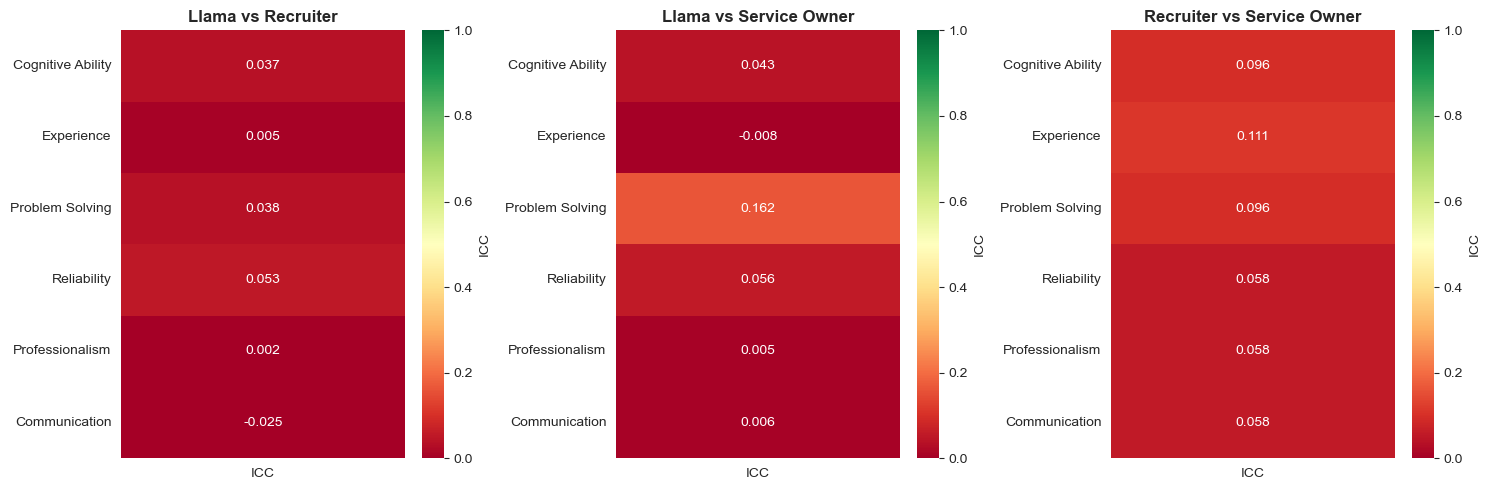


✓ ICC values:
  Green (>0.75): Good to excellent agreement
  Yellow (0.50-0.75): Moderate agreement
  Red (<0.50): Poor agreement


In [13]:
# Create ICC heatmap
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Reshape data for heatmap
icc_matrix_lr = reliability_df.pivot_table(index='metric', values='icc_llama_recruiter').values.reshape(-1, 1)
icc_matrix_lo = reliability_df.pivot_table(index='metric', values='icc_llama_owner').values.reshape(-1, 1)
icc_matrix_ro = reliability_df.pivot_table(index='metric', values='icc_recruiter_owner').values.reshape(-1, 1)

metric_labels = [m.replace('_', ' ').title() for m in METRICS]

# Plot 1: Llama vs Recruiter
sns.heatmap(icc_matrix_lr, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            yticklabels=metric_labels, xticklabels=['ICC'], ax=axes[0], cbar_kws={'label': 'ICC'})
axes[0].set_title('Llama vs Recruiter', fontsize=12, fontweight='bold')

# Plot 2: Llama vs Owner
sns.heatmap(icc_matrix_lo, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            yticklabels=metric_labels, xticklabels=['ICC'], ax=axes[1], cbar_kws={'label': 'ICC'})
axes[1].set_title('Llama vs Service Owner', fontsize=12, fontweight='bold')

# Plot 3: Recruiter vs Owner
sns.heatmap(icc_matrix_ro, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            yticklabels=metric_labels, xticklabels=['ICC'], ax=axes[2], cbar_kws={'label': 'ICC'})
axes[2].set_title('Recruiter vs Service Owner', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ ICC values:")
print("  Green (>0.75): Good to excellent agreement")
print("  Yellow (0.50-0.75): Moderate agreement")
print("  Red (<0.50): Poor agreement")

### 2.4 Visualization: Agreement Rates

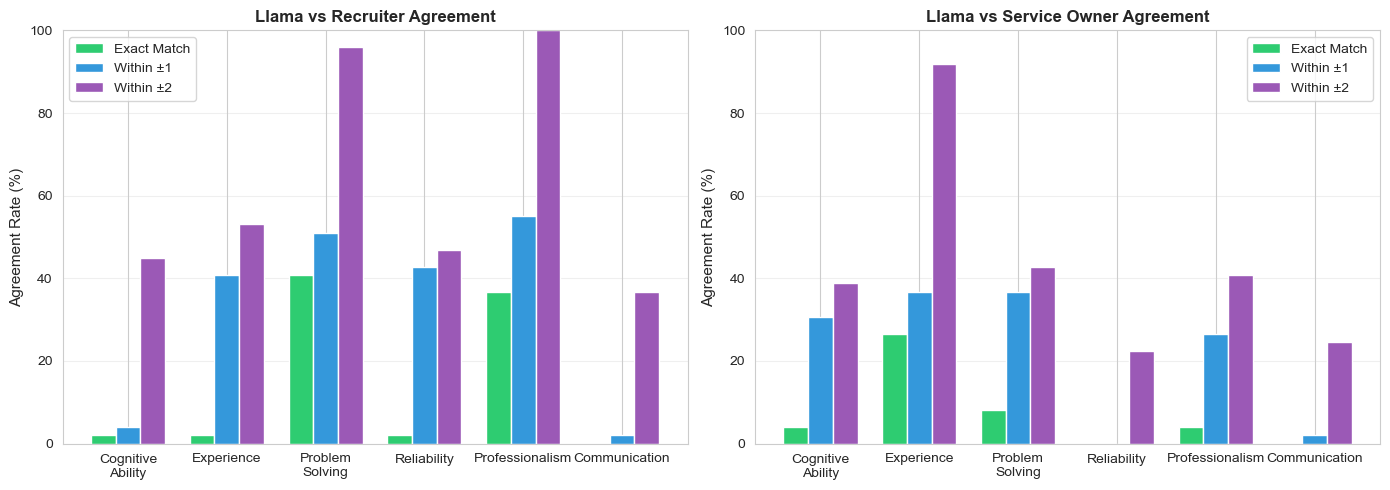

In [14]:
# Plot agreement rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Llama vs Recruiter
x = np.arange(len(METRICS))
width = 0.25

axes[0].bar(x - width, agreement_df['exact_llama_recruiter'], width, label='Exact Match', color='#2ecc71')
axes[0].bar(x, agreement_df['within1_llama_recruiter'], width, label='Within ±1', color='#3498db')
axes[0].bar(x + width, agreement_df['within2_llama_recruiter'], width, label='Within ±2', color='#9b59b6')

axes[0].set_ylabel('Agreement Rate (%)', fontsize=11)
axes[0].set_title('Llama vs Recruiter Agreement', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels([m.replace('_', '\n').title() for m in METRICS], rotation=0, ha='center')
axes[0].legend()
axes[0].set_ylim(0, 100)
axes[0].grid(axis='y', alpha=0.3)

# Llama vs Owner
axes[1].bar(x - width, agreement_df['exact_llama_owner'], width, label='Exact Match', color='#2ecc71')
axes[1].bar(x, agreement_df['within1_llama_owner'], width, label='Within ±1', color='#3498db')
axes[1].bar(x + width, agreement_df['within2_llama_owner'], width, label='Within ±2', color='#9b59b6')

axes[1].set_ylabel('Agreement Rate (%)', fontsize=11)
axes[1].set_title('Llama vs Service Owner Agreement', fontsize=12, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels([m.replace('_', '\n').title() for m in METRICS], rotation=0, ha='center')
axes[1].legend()
axes[1].set_ylim(0, 100)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Score Distribution Analysis

### 3.1 Distribution Comparison

In [15]:
# Calculate overall statistics for each rater
print("=" * 80)
print("SCORE DISTRIBUTION STATISTICS")
print("=" * 80)

for metric in METRICS:
    metric_col = f"{metric}_score"
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    owner_col = f"{metric_col}_owner"
    
    print(f"\n{metric.replace('_', ' ').title()}:")
    
    # Llama
    llama_scores = comparison_df[llama_col].dropna()
    print(f"  Llama: Mean={llama_scores.mean():.2f}, Std={llama_scores.std():.2f}, "
          f"Median={llama_scores.median():.0f}, Range=[{llama_scores.min():.0f}, {llama_scores.max():.0f}]")
    
    # Recruiter
    rec_scores = comparison_df[rec_col].dropna()
    if len(rec_scores) > 0:
        print(f"  Recruiter: Mean={rec_scores.mean():.2f}, Std={rec_scores.std():.2f}, "
              f"Median={rec_scores.median():.0f}, Range=[{rec_scores.min():.0f}, {rec_scores.max():.0f}]")
    
    # Owner
    owner_scores = comparison_df[owner_col].dropna()
    if len(owner_scores) > 0:
        print(f"  Owner: Mean={owner_scores.mean():.2f}, Std={owner_scores.std():.2f}, "
              f"Median={owner_scores.median():.0f}, Range=[{owner_scores.min():.0f}, {owner_scores.max():.0f}]")
    
    # Statistical tests
    if len(rec_scores) > 0 and len(llama_scores) > 0:
        # Wilcoxon signed-rank test (paired)
        mask = comparison_df[llama_col].notna() & comparison_df[rec_col].notna()
        if mask.sum() > 5:
            stat, p = wilcoxon(comparison_df.loc[mask, llama_col], 
                              comparison_df.loc[mask, rec_col])
            sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
            print(f"  Wilcoxon test (Llama vs Recruiter): p={p:.4f} {sig}")
    
    if len(owner_scores) > 0 and len(llama_scores) > 0:
        mask = comparison_df[llama_col].notna() & comparison_df[owner_col].notna()
        if mask.sum() > 5:
            stat, p = wilcoxon(comparison_df.loc[mask, llama_col], 
                              comparison_df.loc[mask, owner_col])
            sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
            print(f"  Wilcoxon test (Llama vs Owner): p={p:.4f} {sig}")

print("\n" + "=" * 80)
print("Significance codes: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")
print("=" * 80)

SCORE DISTRIBUTION STATISTICS

Cognitive Ability:
  Llama: Mean=7.88, Std=0.83, Median=8, Range=[5, 9]
  Recruiter: Mean=4.88, Std=1.00, Median=4, Range=[4, 6]
  Owner: Mean=5.52, Std=0.89, Median=5, Range=[5, 7]
  Wilcoxon test (Llama vs Recruiter): p=0.0000 ***
  Wilcoxon test (Llama vs Owner): p=0.0000 ***

Experience:
  Llama: Mean=7.61, Std=1.30, Median=8, Range=[3, 9]
  Recruiter: Mean=5.88, Std=1.00, Median=5, Range=[5, 7]
  Owner: Mean=6.52, Std=0.89, Median=6, Range=[6, 8]
  Wilcoxon test (Llama vs Recruiter): p=0.0000 ***
  Wilcoxon test (Llama vs Owner): p=0.0000 ***

Problem Solving:
  Llama: Mean=7.61, Std=0.95, Median=8, Range=[4, 8]
  Recruiter: Mean=6.88, Std=1.00, Median=6, Range=[6, 8]
  Owner: Mean=5.52, Std=0.89, Median=5, Range=[5, 7]
  Wilcoxon test (Llama vs Recruiter): p=0.0016 **
  Wilcoxon test (Llama vs Owner): p=0.0000 ***

Reliability:
  Llama: Mean=8.08, Std=0.40, Median=8, Range=[7, 9]
  Recruiter: Mean=5.88, Std=1.00, Median=5, Range=[5, 7]
  Owner: Mean

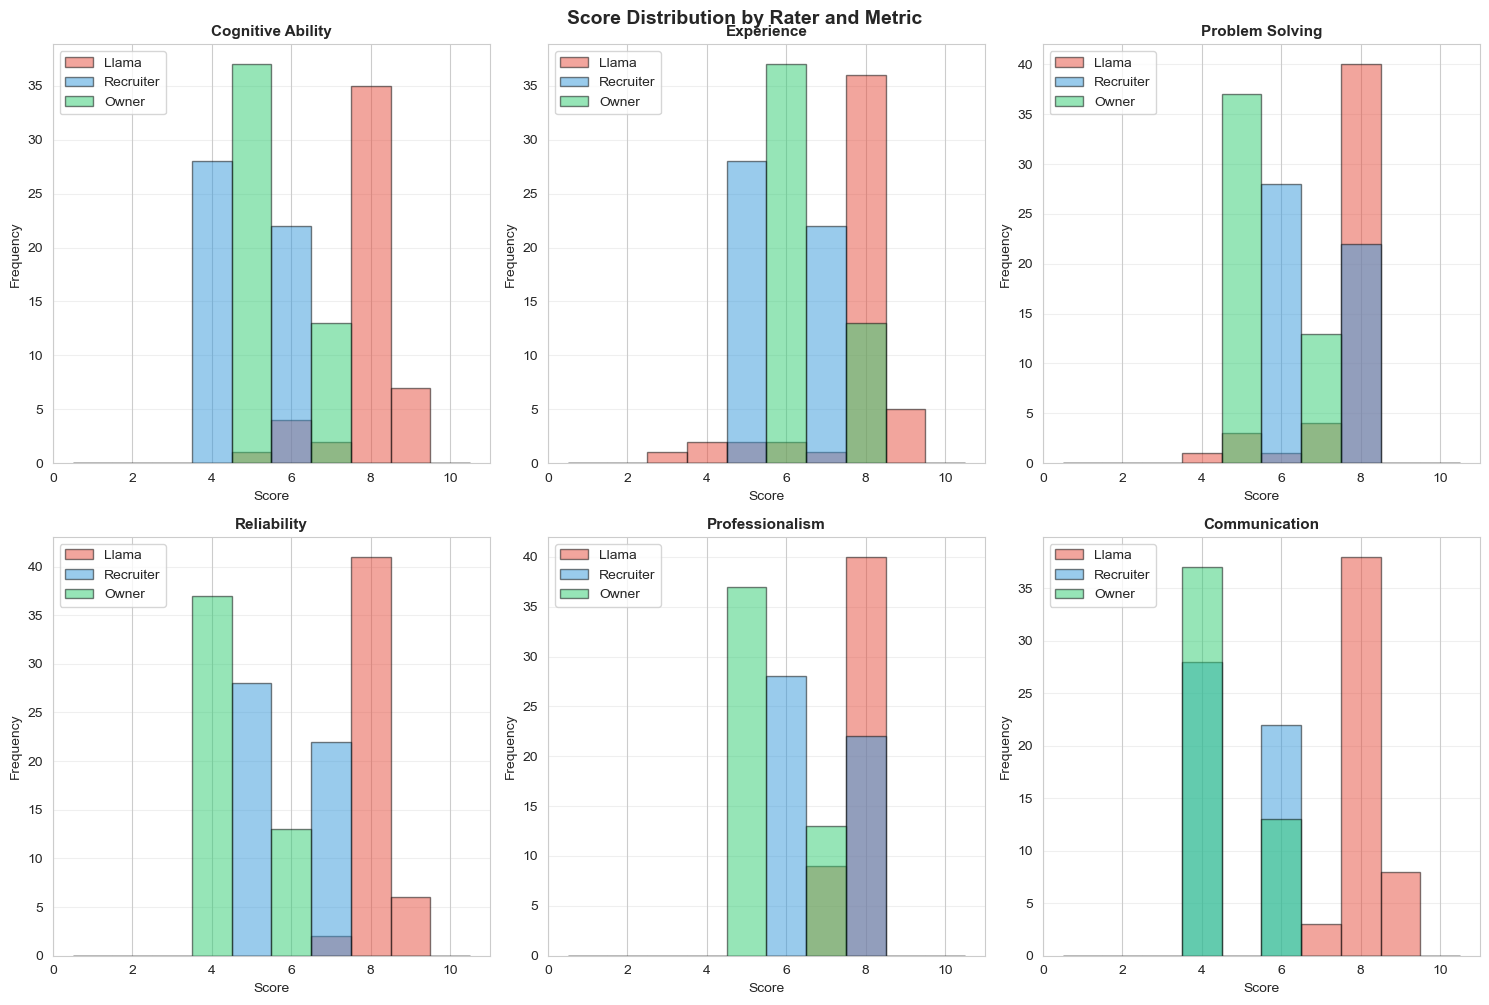

In [16]:
# Visualize distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, metric in enumerate(METRICS):
    metric_col = f"{metric}_score"
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    owner_col = f"{metric_col}_owner"
    
    # Get data
    llama_data = comparison_df[llama_col].dropna()
    rec_data = comparison_df[rec_col].dropna()
    owner_data = comparison_df[owner_col].dropna()
    
    # Plot
    axes[idx].hist(llama_data, bins=np.arange(0.5, 11.5, 1), alpha=0.5, label='Llama', color='#e74c3c', edgecolor='black')
    if len(rec_data) > 0:
        axes[idx].hist(rec_data, bins=np.arange(0.5, 11.5, 1), alpha=0.5, label='Recruiter', color='#3498db', edgecolor='black')
    if len(owner_data) > 0:
        axes[idx].hist(owner_data, bins=np.arange(0.5, 11.5, 1), alpha=0.5, label='Owner', color='#2ecc71', edgecolor='black')
    
    axes[idx].set_xlabel('Score', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    axes[idx].legend()
    axes[idx].set_xlim(0, 11)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.suptitle('Score Distribution by Rater and Metric', fontsize=14, fontweight='bold', y=1.00)
plt.show()

### 3.2 Bias Detection (Bland-Altman Plots)

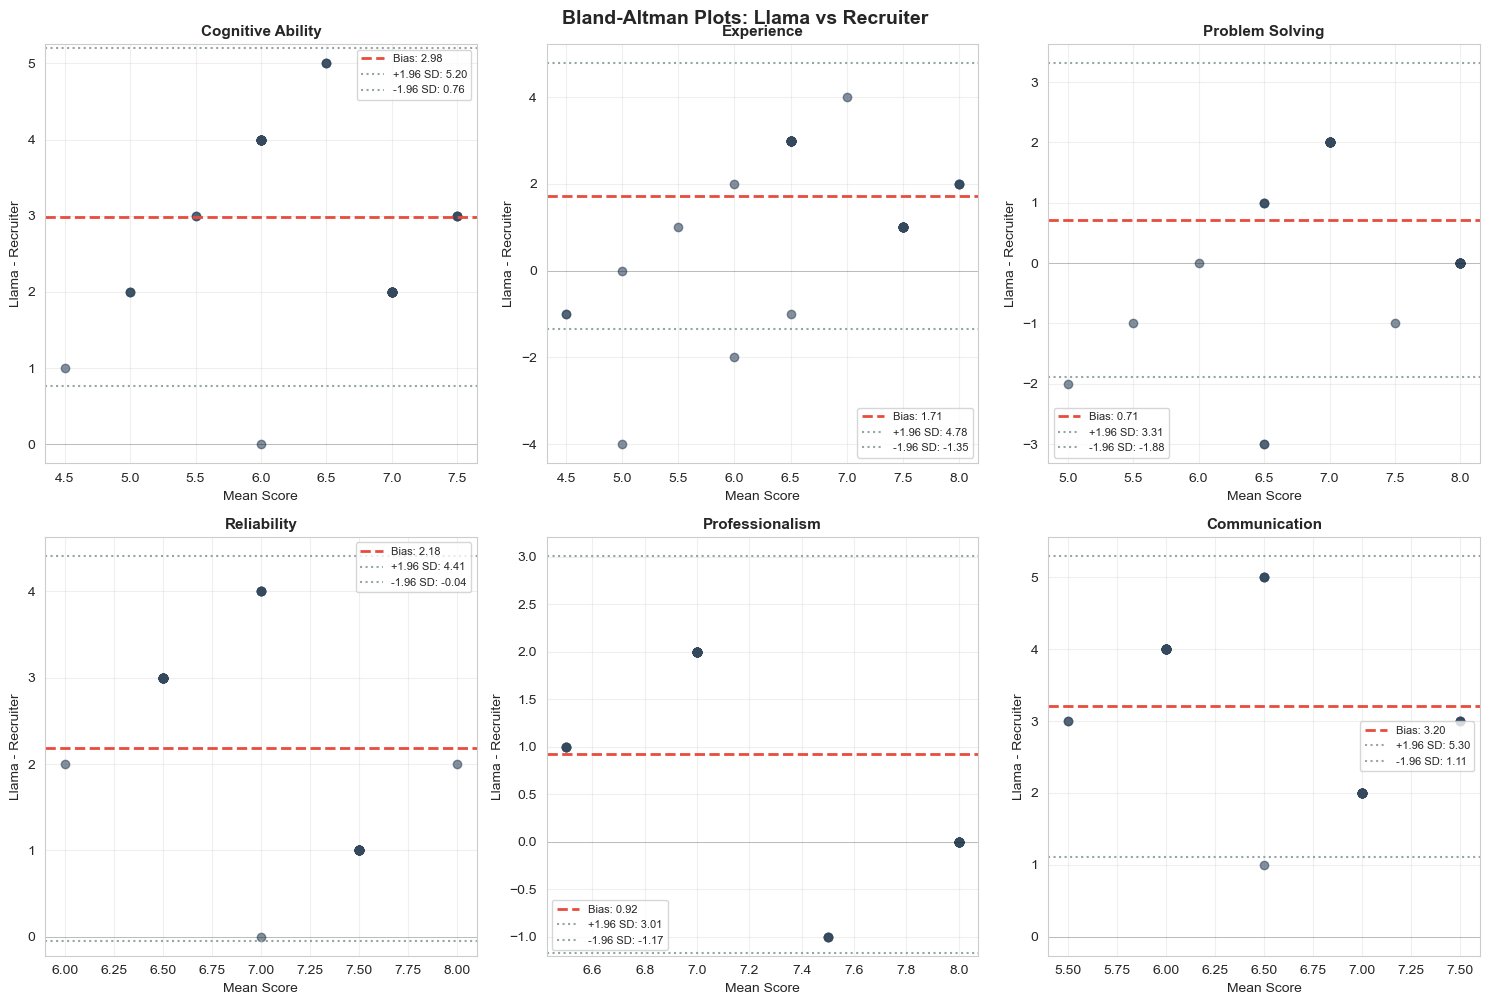


Bland-Altman Interpretation:
  • Points scattered randomly around bias line = no systematic trend
  • Bias significantly different from 0 = systematic over/under-scoring
  • Most points within ±1.96 SD = good agreement
  • Funnel shape = heteroscedasticity (variance increases with score)


In [17]:
# Bland-Altman plots to detect systematic bias
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, metric in enumerate(METRICS):
    metric_col = f"{metric}_score"
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    
    # Get paired data
    mask = comparison_df[llama_col].notna() & comparison_df[rec_col].notna()
    if mask.sum() < 2:
        axes[idx].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
        axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
        continue
    
    llama_vals = comparison_df.loc[mask, llama_col].values
    rec_vals = comparison_df.loc[mask, rec_col].values
    
    # Calculate mean and difference
    mean_vals = (llama_vals + rec_vals) / 2
    diff_vals = llama_vals - rec_vals
    
    # Calculate bias and limits of agreement
    bias = diff_vals.mean()
    std_diff = diff_vals.std()
    upper_loa = bias + 1.96 * std_diff
    lower_loa = bias - 1.96 * std_diff
    
    # Plot
    axes[idx].scatter(mean_vals, diff_vals, alpha=0.6, color='#34495e')
    axes[idx].axhline(bias, color='#e74c3c', linestyle='--', linewidth=2, label=f'Bias: {bias:.2f}')
    axes[idx].axhline(upper_loa, color='#95a5a6', linestyle=':', linewidth=1.5, label=f'+1.96 SD: {upper_loa:.2f}')
    axes[idx].axhline(lower_loa, color='#95a5a6', linestyle=':', linewidth=1.5, label=f'-1.96 SD: {lower_loa:.2f}')
    axes[idx].axhline(0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
    
    axes[idx].set_xlabel('Mean Score', fontsize=10)
    axes[idx].set_ylabel('Llama - Recruiter', fontsize=10)
    axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=8, loc='best')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Bland-Altman Plots: Llama vs Recruiter', fontsize=14, fontweight='bold', y=1.00)
plt.show()

print("\nBland-Altman Interpretation:")
print("  • Points scattered randomly around bias line = no systematic trend")
print("  • Bias significantly different from 0 = systematic over/under-scoring")
print("  • Most points within ±1.96 SD = good agreement")
print("  • Funnel shape = heteroscedasticity (variance increases with score)")

## 4. Metric-by-Metric Deep Dive

### 4.1 Confusion Matrices

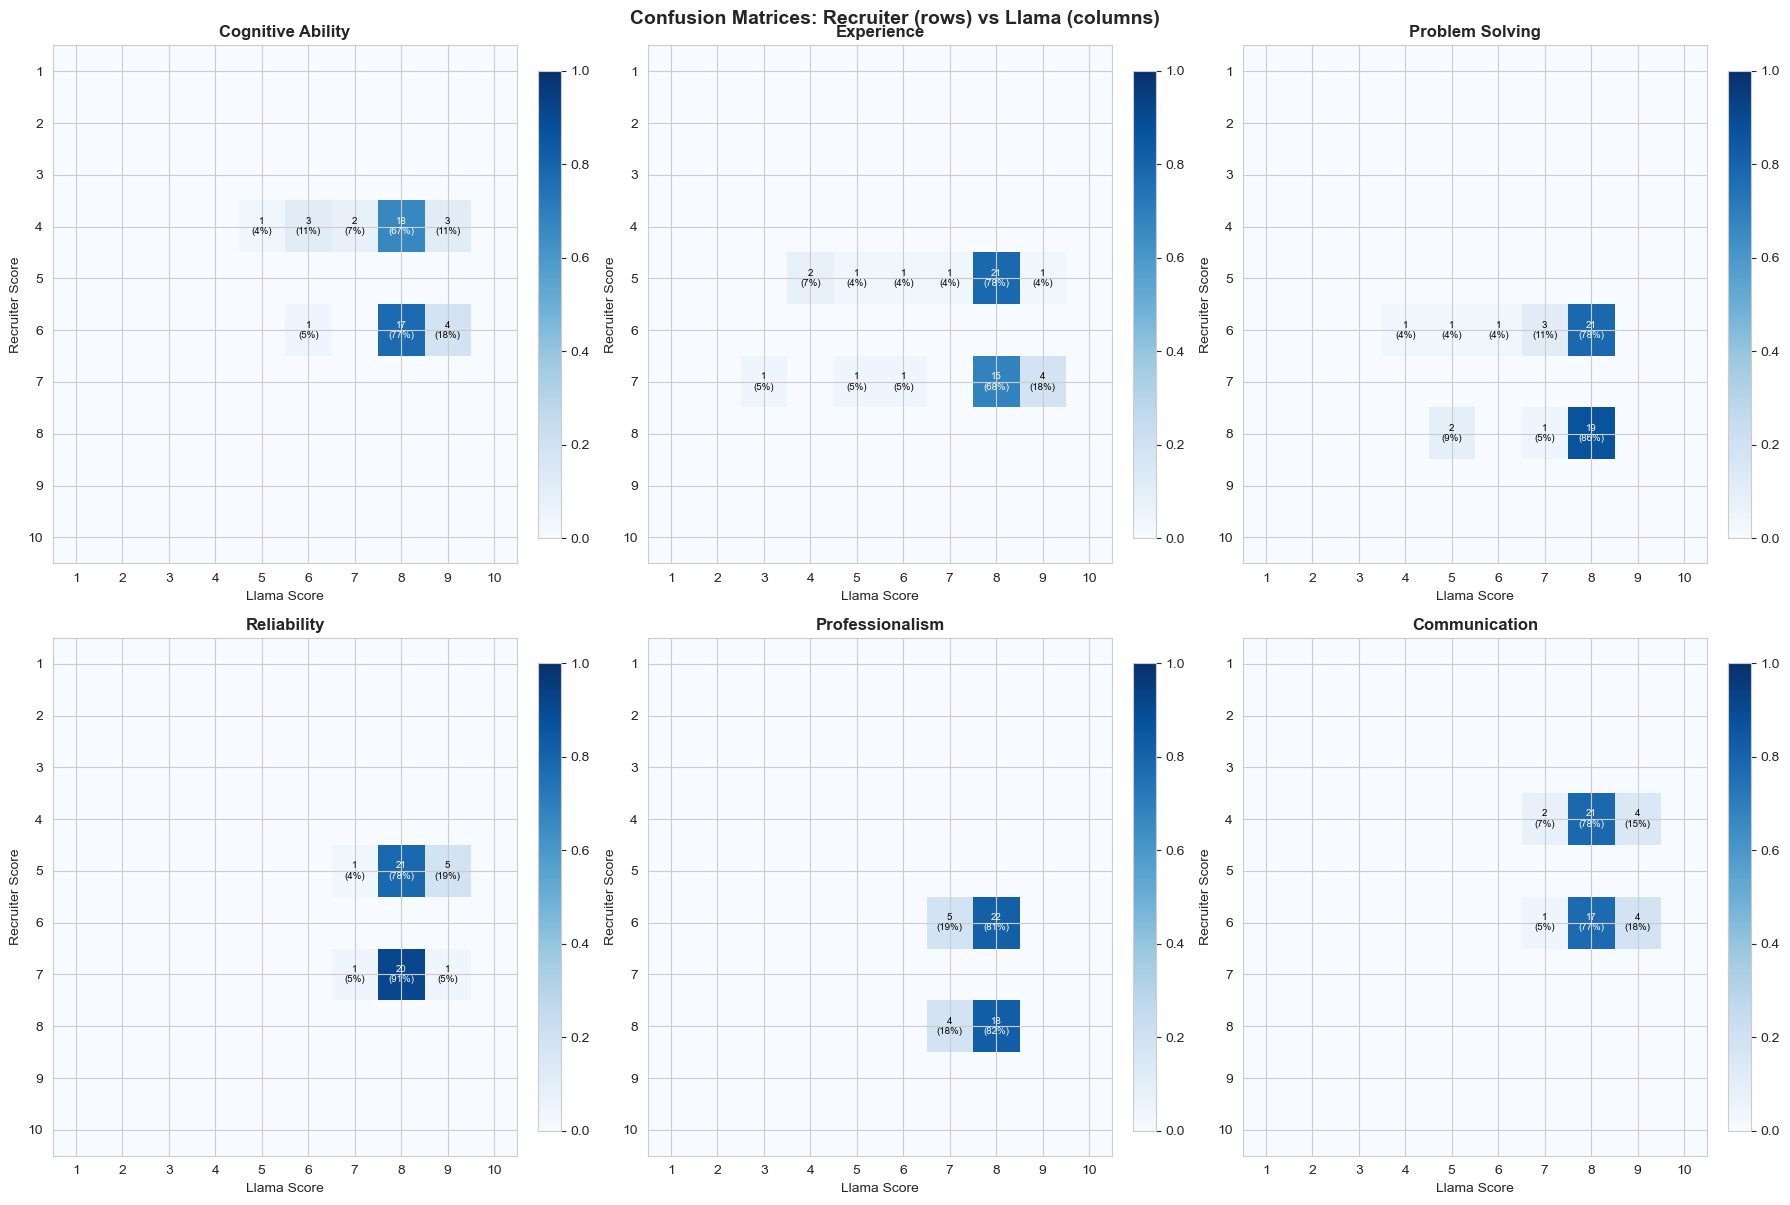


Confusion Matrix Interpretation:
  • Diagonal = exact matches
  • Cells near diagonal = close agreement
  • Dark blue in cell (i,j) = high frequency of Recruiter giving score i when Llama gives j


In [18]:
from sklearn.metrics import confusion_matrix

# Create confusion matrices for each metric
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, metric in enumerate(METRICS):
    metric_col = f"{metric}_score"
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    
    # Get paired data
    mask = comparison_df[llama_col].notna() & comparison_df[rec_col].notna()
    if mask.sum() < 2:
        axes[idx].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
        axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
        continue
    
    llama_vals = comparison_df.loc[mask, llama_col].astype(int).values
    rec_vals = comparison_df.loc[mask, rec_col].astype(int).values
    
    # Create confusion matrix
    cm = confusion_matrix(rec_vals, llama_vals, labels=range(1, 11))
    
    # Normalize by row (true label)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)
    
    # Plot
    im = axes[idx].imshow(cm_normalized, cmap='Blues', aspect='auto', vmin=0, vmax=1)
    
    # Add text annotations
    for i in range(len(cm_normalized)):
        for j in range(len(cm_normalized[0])):
            if cm[i, j] > 0:
                text = axes[idx].text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.0%})',
                                    ha="center", va="center", color="white" if cm_normalized[i, j] > 0.5 else "black",
                                    fontsize=7)
    
    axes[idx].set_xlabel('Llama Score', fontsize=10)
    axes[idx].set_ylabel('Recruiter Score', fontsize=10)
    axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    axes[idx].set_xticks(range(10))
    axes[idx].set_yticks(range(10))
    axes[idx].set_xticklabels(range(1, 11))
    axes[idx].set_yticklabels(range(1, 11))
    
    # Add colorbar
    plt.colorbar(im, ax=axes[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.suptitle('Confusion Matrices: Recruiter (rows) vs Llama (columns)', fontsize=14, fontweight='bold', y=1.00)
plt.show()

print("\nConfusion Matrix Interpretation:")
print("  • Diagonal = exact matches")
print("  • Cells near diagonal = close agreement")
print("  • Dark blue in cell (i,j) = high frequency of Recruiter giving score i when Llama gives j")

### 4.2 Scatter Plots with Regression

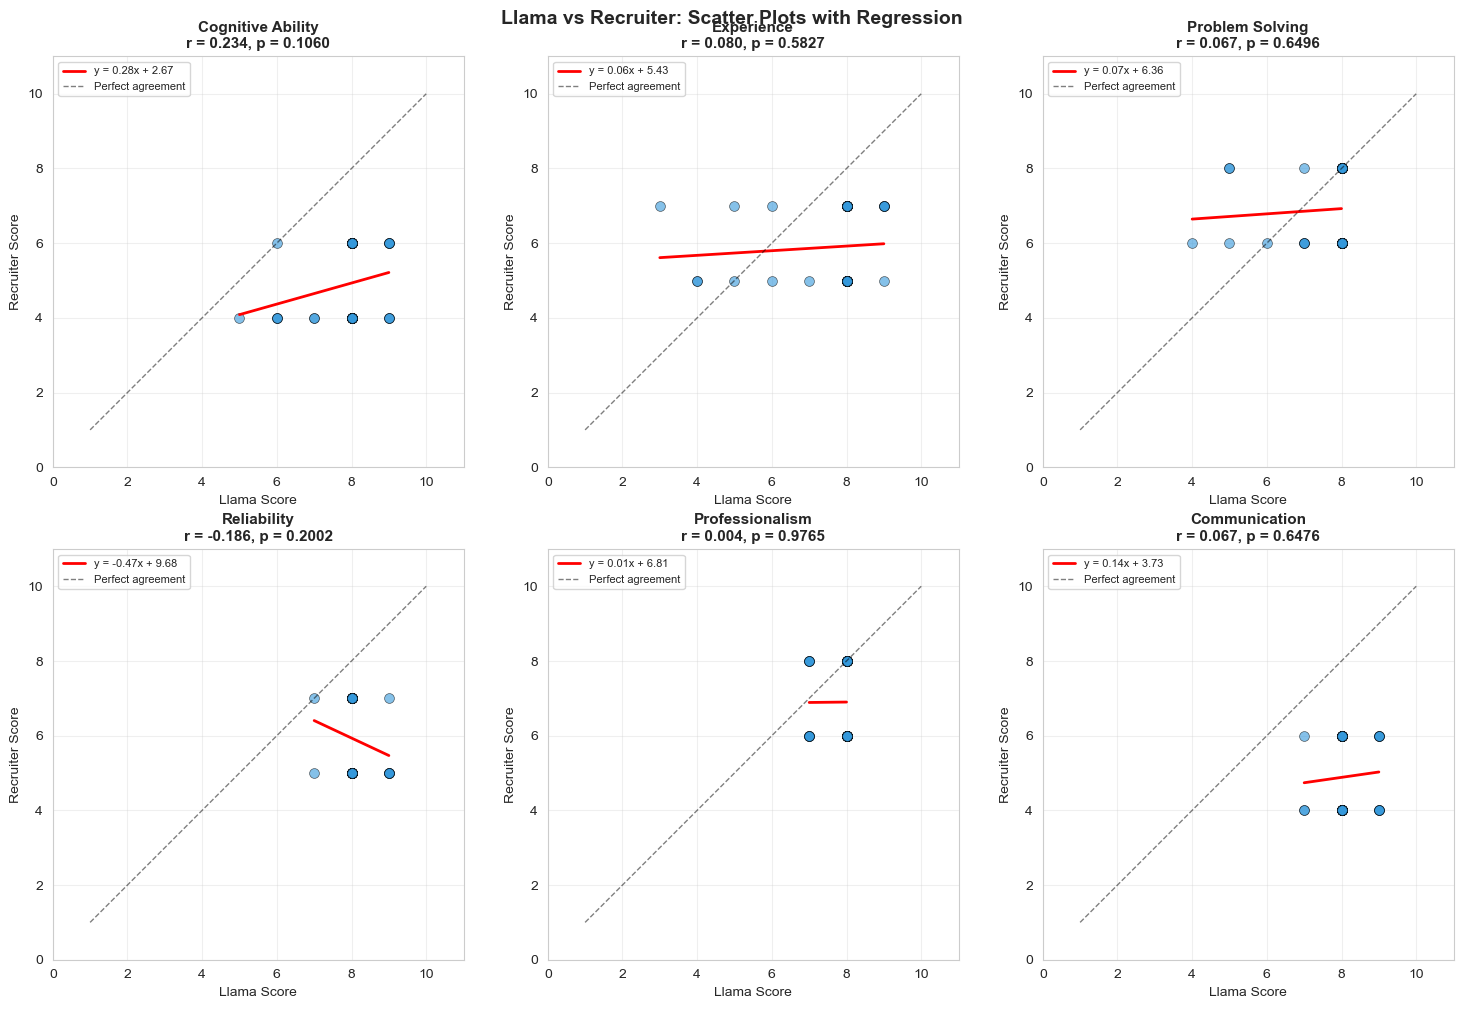

In [19]:
from scipy.stats import linregress

# Scatter plots with regression lines
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, metric in enumerate(METRICS):
    metric_col = f"{metric}_score"
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    
    # Get paired data
    mask = comparison_df[llama_col].notna() & comparison_df[rec_col].notna()
    if mask.sum() < 2:
        axes[idx].text(0.5, 0.5, 'Insufficient data', ha='center', va='center')
        axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=11, fontweight='bold')
        continue
    
    llama_vals = comparison_df.loc[mask, llama_col].values
    rec_vals = comparison_df.loc[mask, rec_col].values
    
    # Regression
    slope, intercept, r_value, p_value, std_err = linregress(llama_vals, rec_vals)
    
    # Plot
    axes[idx].scatter(llama_vals, rec_vals, alpha=0.6, s=50, color='#3498db', edgecolor='black', linewidth=0.5)
    
    # Regression line
    x_line = np.linspace(llama_vals.min(), llama_vals.max(), 100)
    y_line = slope * x_line + intercept
    axes[idx].plot(x_line, y_line, 'r-', linewidth=2, label=f'y = {slope:.2f}x + {intercept:.2f}')
    
    # Identity line (perfect agreement)
    axes[idx].plot([1, 10], [1, 10], 'k--', linewidth=1, alpha=0.5, label='Perfect agreement')
    
    axes[idx].set_xlabel('Llama Score', fontsize=10)
    axes[idx].set_ylabel('Recruiter Score', fontsize=10)
    axes[idx].set_title(f"{metric.replace('_', ' ').title()}\nr = {r_value:.3f}, p = {p_value:.4f}", 
                       fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=8, loc='best')
    axes[idx].set_xlim(0, 11)
    axes[idx].set_ylim(0, 11)
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_aspect('equal')

plt.tight_layout()
plt.suptitle('Llama vs Recruiter: Scatter Plots with Regression', fontsize=14, fontweight='bold', y=1.00)
plt.show()

## 5. Disagreement Analysis

### 5.1 High-Disagreement Cases

In [20]:
# Calculate disagreement scores for each interview
disagreement_data = []

for _, row in comparison_df.iterrows():
    interview_id = row['interview_id']
    
    # Calculate MAE across all metrics
    mae_recruiter = 0
    mae_owner = 0
    count_rec = 0
    count_owner = 0
    
    for metric in METRICS:
        metric_col = f"{metric}_score"
        llama_col = f"{metric_col}_llama"
        rec_col = f"{metric_col}_recruiter"
        owner_col = f"{metric_col}_owner"
        
        if pd.notna(row[llama_col]) and pd.notna(row[rec_col]):
            mae_recruiter += abs(row[llama_col] - row[rec_col])
            count_rec += 1
        
        if pd.notna(row[llama_col]) and pd.notna(row[owner_col]):
            mae_owner += abs(row[llama_col] - row[owner_col])
            count_owner += 1
    
    disagreement_data.append({
        'interview_id': interview_id,
        'mae_recruiter': mae_recruiter / count_rec if count_rec > 0 else np.nan,
        'mae_owner': mae_owner / count_owner if count_owner > 0 else np.nan
    })

disagreement_df = pd.DataFrame(disagreement_data)

# Find high disagreement cases
print("=" * 80)
print("HIGH DISAGREEMENT CASES")
print("=" * 80)

print("\nTop 10 interviews with highest disagreement (Llama vs Recruiter):")
top_disagreement = disagreement_df.nlargest(10, 'mae_recruiter')
display(top_disagreement)

# Show score details for top disagreement case
if len(top_disagreement) > 0:
    worst_case_id = top_disagreement.iloc[0]['interview_id']
    print(f"\n\nDetailed scores for highest disagreement case: {worst_case_id}")
    print("=" * 80)
    
    case_row = comparison_df[comparison_df['interview_id'] == worst_case_id].iloc[0]
    
    print(f"{'Metric':<25} {'Llama':<10} {'Recruiter':<12} {'Difference':<12}")
    print("-" * 80)
    for metric in METRICS:
        metric_col = f"{metric}_score"
        llama_val = case_row[f"{metric_col}_llama"]
        rec_val = case_row[f"{metric_col}_recruiter"]
        if pd.notna(llama_val) and pd.notna(rec_val):
            diff = llama_val - rec_val
            print(f"{metric.replace('_', ' ').title():<25} {llama_val:<10.0f} {rec_val:<12.0f} {diff:+.0f}")

print("\n" + "=" * 80)

HIGH DISAGREEMENT CASES

Top 10 interviews with highest disagreement (Llama vs Recruiter):


,interview_id,mae_recruiter,mae_owner
45,intv_0046,3.500000,1.666667
0,intv_0001,3.166667,3.333333
1,intv_0002,3.166667,1.333333
17,intv_0018,3.166667,3.333333
21,intv_0022,3.166667,1.333333
22,intv_0023,3.166667,3.333333
27,intv_0028,3.166667,3.333333
34,intv_0035,3.166667,3.333333
46,intv_0047,3.166667,3.333333
7,intv_0008,3.000000,3.166667




Detailed scores for highest disagreement case: intv_0046
Metric                    Llama      Recruiter    Difference  
--------------------------------------------------------------------------------
Cognitive Ability         9          4            +5
Experience                8          5            +3
Problem Solving           8          6            +2
Reliability               9          5            +4
Professionalism           8          6            +2
Communication             9          4            +5



### 5.2 Agreement Heatmap

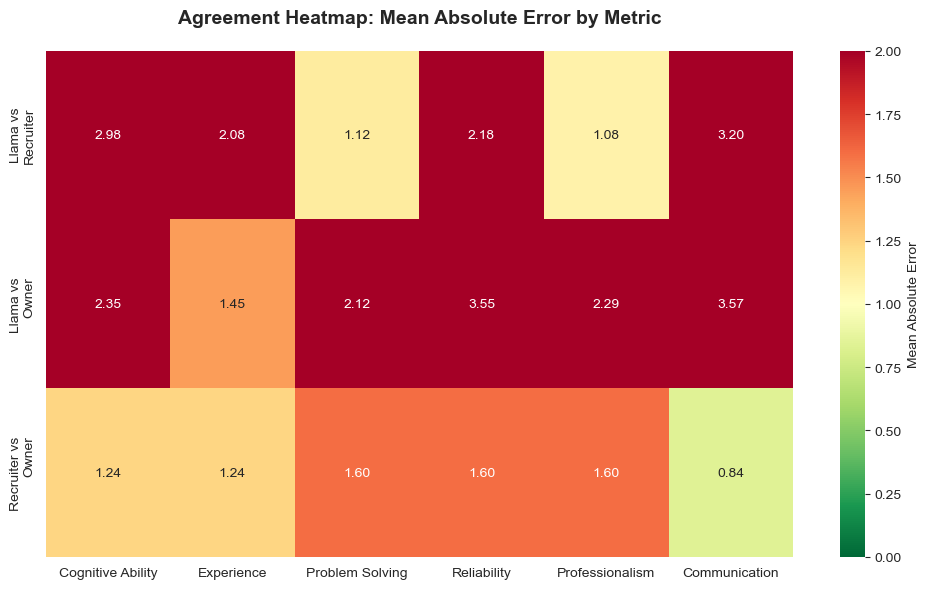


Interpretation:
  Green (MAE < 0.5): Excellent agreement
  Yellow (MAE 0.5-1.0): Good agreement
  Orange (MAE 1.0-1.5): Moderate agreement
  Red (MAE > 1.5): Poor agreement


In [21]:
# Create agreement heatmap showing MAE for each metric and rater pair
mae_data = []

for metric in METRICS:
    metric_col = f"{metric}_score"
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    owner_col = f"{metric_col}_owner"
    
    # Llama vs Recruiter
    mask_lr = comparison_df[llama_col].notna() & comparison_df[rec_col].notna()
    mae_lr = (comparison_df.loc[mask_lr, llama_col] - comparison_df.loc[mask_lr, rec_col]).abs().mean()
    
    # Llama vs Owner
    mask_lo = comparison_df[llama_col].notna() & comparison_df[owner_col].notna()
    mae_lo = (comparison_df.loc[mask_lo, llama_col] - comparison_df.loc[mask_lo, owner_col]).abs().mean()
    
    # Recruiter vs Owner
    mask_ro = comparison_df[rec_col].notna() & comparison_df[owner_col].notna()
    mae_ro = (comparison_df.loc[mask_ro, rec_col] - comparison_df.loc[mask_ro, owner_col]).abs().mean()
    
    mae_data.append({
        'metric': metric,
        'Llama vs\nRecruiter': mae_lr,
        'Llama vs\nOwner': mae_lo,
        'Recruiter vs\nOwner': mae_ro
    })

mae_matrix_df = pd.DataFrame(mae_data).set_index('metric')

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(mae_matrix_df.T, annot=True, fmt='.2f', cmap='RdYlGn_r', 
            vmin=0, vmax=2, cbar_kws={'label': 'Mean Absolute Error'},
            xticklabels=[m.replace('_', ' ').title() for m in METRICS])
plt.title('Agreement Heatmap: Mean Absolute Error by Metric', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  Green (MAE < 0.5): Excellent agreement")
print("  Yellow (MAE 0.5-1.0): Good agreement")
print("  Orange (MAE 1.0-1.5): Moderate agreement")
print("  Red (MAE > 1.5): Poor agreement")

### 5.3 Systematic Bias Analysis

SYSTEMATIC BIAS ANALYSIS (Human - Llama)

Positive values: Humans score higher than Llama
Negative values: Llama scores higher than Humans

Cognitive Ability         Recruiter: -2.98   Owner: -2.35
Experience                Recruiter: -1.71   Owner: -1.08
Problem Solving           Recruiter: -0.71   Owner: -2.08
Reliability               Recruiter: -2.18   Owner: -3.55
Professionalism           Recruiter: -0.92   Owner: -2.29
Communication             Recruiter: -3.20   Owner: -3.57


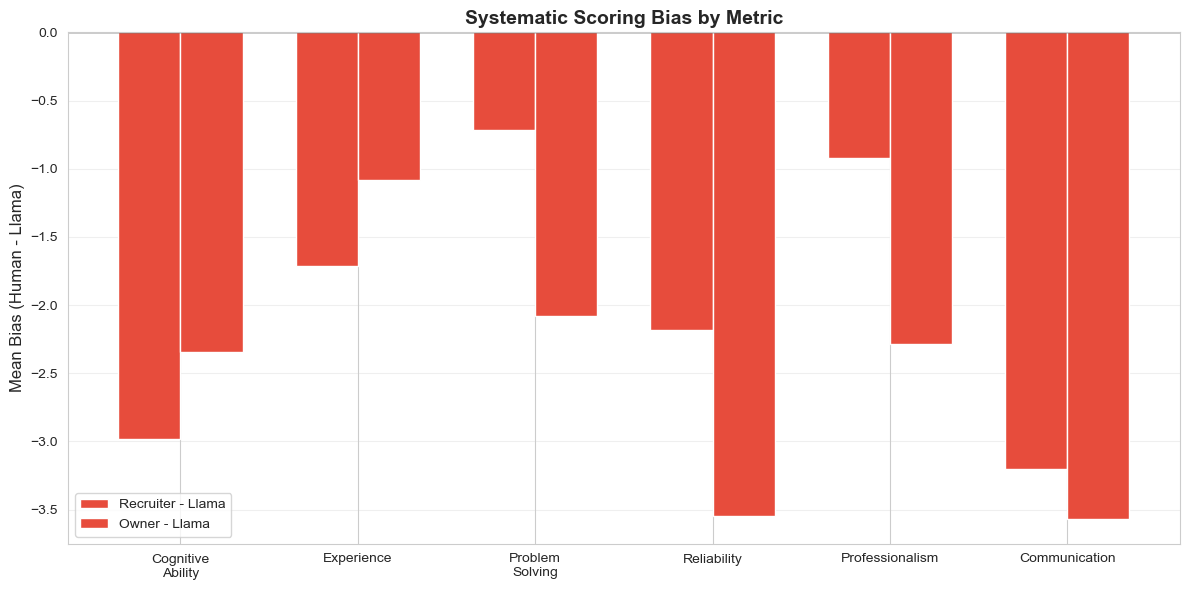



Key Findings:
  Average Recruiter bias: -1.95
  Average Owner bias: -2.49
  ⚠️ Recruiter tends to score LOWER than Llama
  ⚠️ Owner tends to score LOWER than Llama


In [22]:
# Calculate mean bias (Human - Llama) for each metric
bias_data = []

print("=" * 80)
print("SYSTEMATIC BIAS ANALYSIS (Human - Llama)")
print("=" * 80)
print("\nPositive values: Humans score higher than Llama")
print("Negative values: Llama scores higher than Humans\n")

for metric in METRICS:
    metric_col = f"{metric}_score"
    llama_col = f"{metric_col}_llama"
    rec_col = f"{metric_col}_recruiter"
    owner_col = f"{metric_col}_owner"
    
    # Recruiter bias
    mask_lr = comparison_df[llama_col].notna() & comparison_df[rec_col].notna()
    bias_rec = (comparison_df.loc[mask_lr, rec_col] - comparison_df.loc[mask_lr, llama_col]).mean()
    
    # Owner bias
    mask_lo = comparison_df[llama_col].notna() & comparison_df[owner_col].notna()
    bias_owner = (comparison_df.loc[mask_lo, owner_col] - comparison_df.loc[mask_lo, llama_col]).mean()
    
    print(f"{metric.replace('_', ' ').title():<25} Recruiter: {bias_rec:+.2f}   Owner: {bias_owner:+.2f}")
    
    bias_data.append({
        'metric': metric,
        'recruiter_bias': bias_rec,
        'owner_bias': bias_owner
    })

bias_df = pd.DataFrame(bias_data)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(METRICS))
width = 0.35

bars1 = ax.bar(x - width/2, bias_df['recruiter_bias'], width, label='Recruiter - Llama',
               color=['#e74c3c' if b < 0 else '#3498db' for b in bias_df['recruiter_bias']])
bars2 = ax.bar(x + width/2, bias_df['owner_bias'], width, label='Owner - Llama',
               color=['#e74c3c' if b < 0 else '#2ecc71' for b in bias_df['owner_bias']])

ax.axhline(0, color='black', linewidth=1, linestyle='-')
ax.set_ylabel('Mean Bias (Human - Llama)', fontsize=12)
ax.set_title('Systematic Scoring Bias by Metric', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([m.replace('_', '\n').title() for m in METRICS])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("\nKey Findings:")
avg_rec_bias = bias_df['recruiter_bias'].mean()
avg_owner_bias = bias_df['owner_bias'].mean()
print(f"  Average Recruiter bias: {avg_rec_bias:+.2f}")
print(f"  Average Owner bias: {avg_owner_bias:+.2f}")

if avg_rec_bias > 0.5:
    print("  ⚠️ Recruiter tends to score HIGHER than Llama")
elif avg_rec_bias < -0.5:
    print("  ⚠️ Recruiter tends to score LOWER than Llama")
else:
    print("  ✓ Recruiter scores are well-calibrated with Llama")

if avg_owner_bias > 0.5:
    print("  ⚠️ Owner tends to score HIGHER than Llama")
elif avg_owner_bias < -0.5:
    print("  ⚠️ Owner tends to score LOWER than Llama")
else:
    print("  ✓ Owner scores are well-calibrated with Llama")
print("=" * 80)

## 6. Summary & Recommendations

In [23]:
print("=" * 80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("=" * 80)

# Overall statistics
print("\n1. INTER-RATER RELIABILITY")
print("-" * 80)
print(f"Average ICC (Llama vs Recruiter): {reliability_df['icc_llama_recruiter'].mean():.3f}")
print(f"Average ICC (Llama vs Owner): {reliability_df['icc_llama_owner'].mean():.3f}")
print(f"Average ICC (Recruiter vs Owner): {reliability_df['icc_recruiter_owner'].mean():.3f}")

# Best and worst metrics
best_metric = reliability_df.loc[reliability_df['icc_llama_recruiter'].idxmax(), 'metric']
worst_metric = reliability_df.loc[reliability_df['icc_llama_recruiter'].idxmin(), 'metric']
print(f"\nBest agreement metric: {best_metric.replace('_', ' ').title()}")
print(f"Weakest agreement metric: {worst_metric.replace('_', ' ').title()}")

print("\n2. AGREEMENT RATES")
print("-" * 80)
avg_exact = agreement_df['exact_llama_recruiter'].mean()
avg_within1 = agreement_df['within1_llama_recruiter'].mean()
avg_within2 = agreement_df['within2_llama_recruiter'].mean()
print(f"Average exact match rate: {avg_exact:.1f}%")
print(f"Average within ±1 agreement: {avg_within1:.1f}%")
print(f"Average within ±2 agreement: {avg_within2:.1f}%")

print("\n3. SYSTEMATIC BIAS")
print("-" * 80)
overall_rec_bias = bias_df['recruiter_bias'].mean()
overall_owner_bias = bias_df['owner_bias'].mean()
print(f"Overall Recruiter bias: {overall_rec_bias:+.2f} points")
print(f"Overall Owner bias: {overall_owner_bias:+.2f} points")

print("\n4. KEY RECOMMENDATIONS")
print("-" * 80)

# Generate recommendations based on analysis
recommendations = []

if avg_within1 > 75:
    recommendations.append("✓ Strong overall agreement - Llama can be used with confidence")
elif avg_within1 > 60:
    recommendations.append("⚠️ Moderate agreement - Consider human review for edge cases")
else:
    recommendations.append("⚠️ Weak agreement - Significant calibration needed")

if abs(overall_rec_bias) > 0.5:
    if overall_rec_bias > 0:
        recommendations.append(f"⚠️ Recruiter systematically scores {overall_rec_bias:.2f} points higher - Consider calibration")
    else:
        recommendations.append(f"⚠️ Llama systematically scores {-overall_rec_bias:.2f} points higher - Review scoring criteria")

if worst_metric:
    recommendations.append(f"⚠️ Focus calibration efforts on '{worst_metric.replace('_', ' ').title()}' - weakest agreement")

# Check for high-variance metrics
high_variance_metrics = []
for metric in METRICS:
    llama_col = f"{metric}_score_llama"
    if comparison_df[llama_col].std() > 1.5:
        high_variance_metrics.append(metric)

if high_variance_metrics:
    recommendations.append(f"⚠️ High variance in: {', '.join([m.replace('_', ' ').title() for m in high_variance_metrics])}")

for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

print("\n5. NEXT STEPS")
print("-" * 80)
print("1. Review high-disagreement cases to identify patterns")
print("2. Calibrate human raters if systematic bias is detected")
print("3. Refine Llama prompts for metrics with weak agreement")
print("4. Consider ensemble approach (Llama + human) for critical decisions")
print("5. Monitor agreement rates over time as system evolves")

print("\n" + "=" * 80)
print("END OF ANALYSIS")
print("=" * 80)

COMPREHENSIVE ANALYSIS SUMMARY

1. INTER-RATER RELIABILITY
--------------------------------------------------------------------------------
Average ICC (Llama vs Recruiter): 0.018
Average ICC (Llama vs Owner): 0.044
Average ICC (Recruiter vs Owner): 0.080

Best agreement metric: Problem Solving
Weakest agreement metric: Reliability

2. AGREEMENT RATES
--------------------------------------------------------------------------------
Average exact match rate: 13.9%
Average within ±1 agreement: 32.7%
Average within ±2 agreement: 62.9%

3. SYSTEMATIC BIAS
--------------------------------------------------------------------------------
Overall Recruiter bias: -1.95 points
Overall Owner bias: -2.49 points

4. KEY RECOMMENDATIONS
--------------------------------------------------------------------------------
1. ⚠️ Weak agreement - Significant calibration needed
2. ⚠️ Llama systematically scores 1.95 points higher - Review scoring criteria
3. ⚠️ Focus calibration efforts on 'Reliability' - wea

## Export Results

In [24]:
# Save all analysis results
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = "/Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/analysis_results"

import os
os.makedirs(output_dir, exist_ok=True)

# Save dataframes
reliability_df.to_csv(f"{output_dir}/reliability_metrics_{timestamp}.csv", index=False)
agreement_df.to_csv(f"{output_dir}/agreement_rates_{timestamp}.csv", index=False)
bias_df.to_csv(f"{output_dir}/bias_analysis_{timestamp}.csv", index=False)
disagreement_df.to_csv(f"{output_dir}/disagreement_scores_{timestamp}.csv", index=False)
comparison_df.to_csv(f"{output_dir}/full_comparison_{timestamp}.csv", index=False)

print(f"✓ Results saved to: {output_dir}")
print(f"  - reliability_metrics_{timestamp}.csv")
print(f"  - agreement_rates_{timestamp}.csv")
print(f"  - bias_analysis_{timestamp}.csv")
print(f"  - disagreement_scores_{timestamp}.csv")
print(f"  - full_comparison_{timestamp}.csv")

✓ Results saved to: /Users/shreya_sudan/Desktop/ServiceAgent/CleanAgent/metaPromptOpt/data/analysis_results
  - reliability_metrics_20251104_162048.csv
  - agreement_rates_20251104_162048.csv
  - bias_analysis_20251104_162048.csv
  - disagreement_scores_20251104_162048.csv
  - full_comparison_20251104_162048.csv
